
=== Running test with synthetic data ===

Generating 3 sets of eyes open/closed recordings (30 seconds each)...
Generating sample data for eyes_open condition...
Generating sample data for eyes_closed condition...
Generating visual evoked potential data (checkerboard pattern at 1.93 Hz)...
Generating sample data for vep condition...
Loading and preprocessing data...
Creating RawArray with float64 data, n_channels=15, n_times=27000
    Range : 0 ... 26999 =      0.000 ...    89.997 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=27000
    Range : 0 ... 26999 =      0.000 ...    89.997 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=27000
    Range : 0 ... 26999 =      0.000 ...    89.997 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=27000
    Range : 0 ... 26999 =      0.000 ...    89.997 secs
Ready.
Analyzing alpha waves between eyes open and closed conditions...
Effective window size : 4.000 (s)
Effective window

C:\Users\mhfar\AppData\Local\Temp\ipykernel_25056\2669053722.py:248: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
C:\Users\mhfar\AppData\Local\Temp\ipykernel_25056\2669053722.py:248: RuntimeWarning: DigMontage is only a subset of info. There are 3 channel positions not present in the DigMontage. The channels missing from the montage are:

['Disc_Pz', 'TCRE_PzOz', 'Ref'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
C:\Users\mhfar\AppData\Local\Temp\ipykernel_25056\2669053722.py:248: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
C:\Users\mhfar\AppData\Local\Temp\ipykernel_25056\2669053722.py:248: RuntimeWarning: DigMontage is only a subset of info. There are 3 channel positions not present in the DigMo

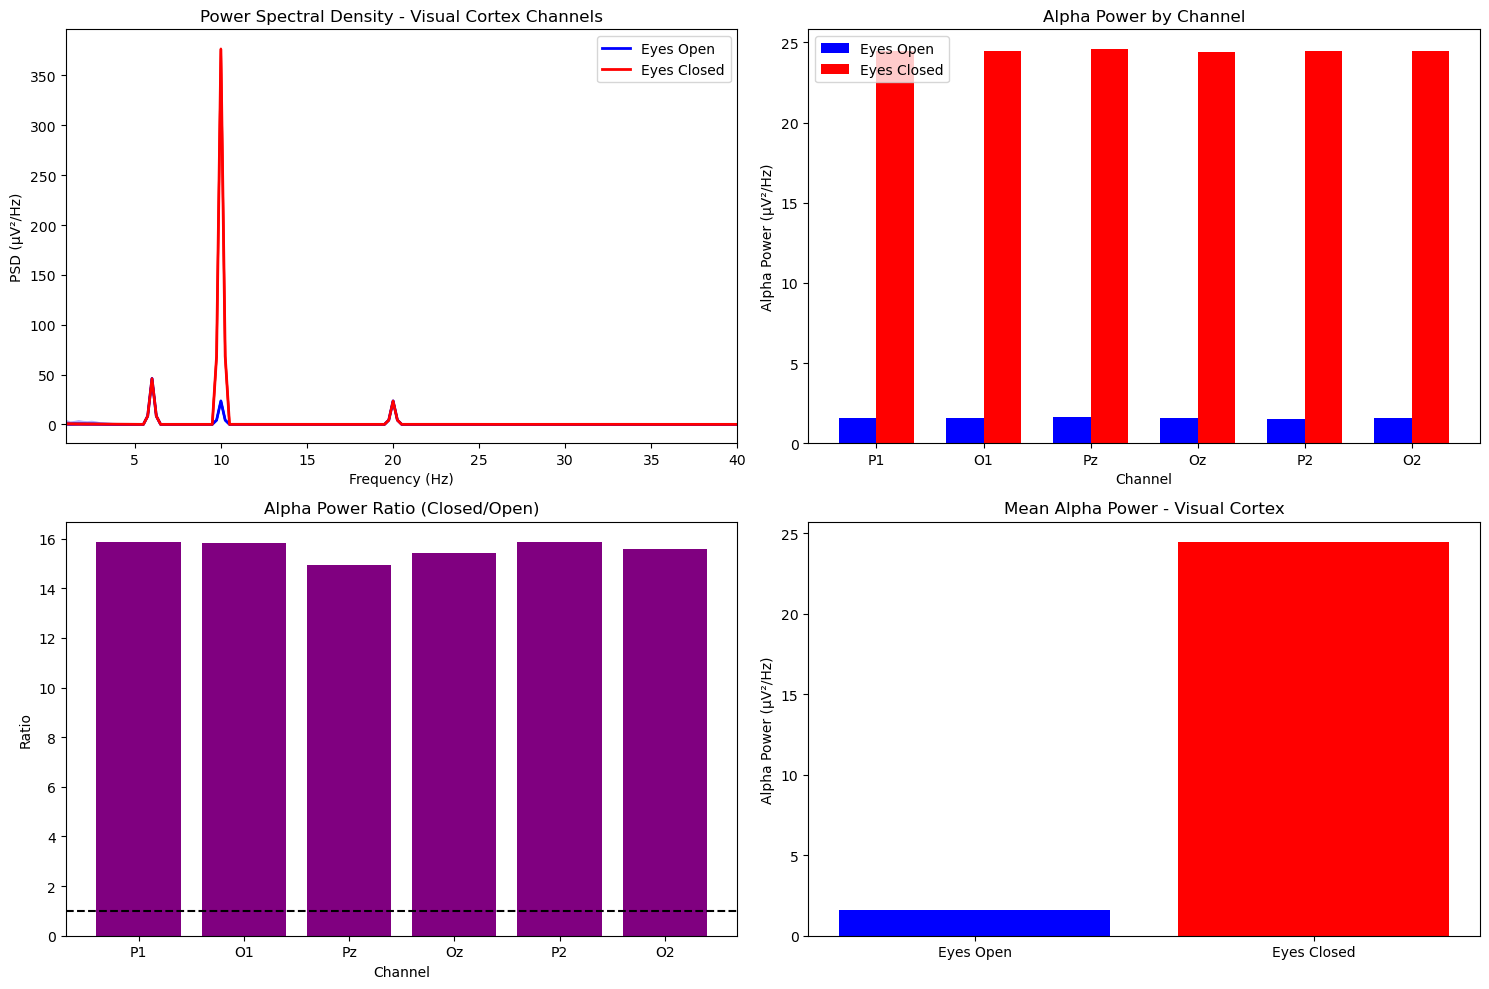

Mean alpha power (eyes open): 1.57 µV²/Hz
Mean alpha power (eyes closed): 24.49 µV²/Hz
Alpha power ratio (closed/open): 15.58
Analyzing Visual Evoked Potentials...
Trigger channel Trigger has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
173 events found on stim channel Trigger
Event IDs: [1]
Found 173 visual stimulus events at ~1.93 Hz (518 ms interval).
Not setting metadata
173 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 173 events and 121 original time points ...
0 bad epochs dropped


ValueError: The following electrodes have overlapping positions, which causes problems during visualization:
Disc_Pz, TCRE_PzOz, Ref

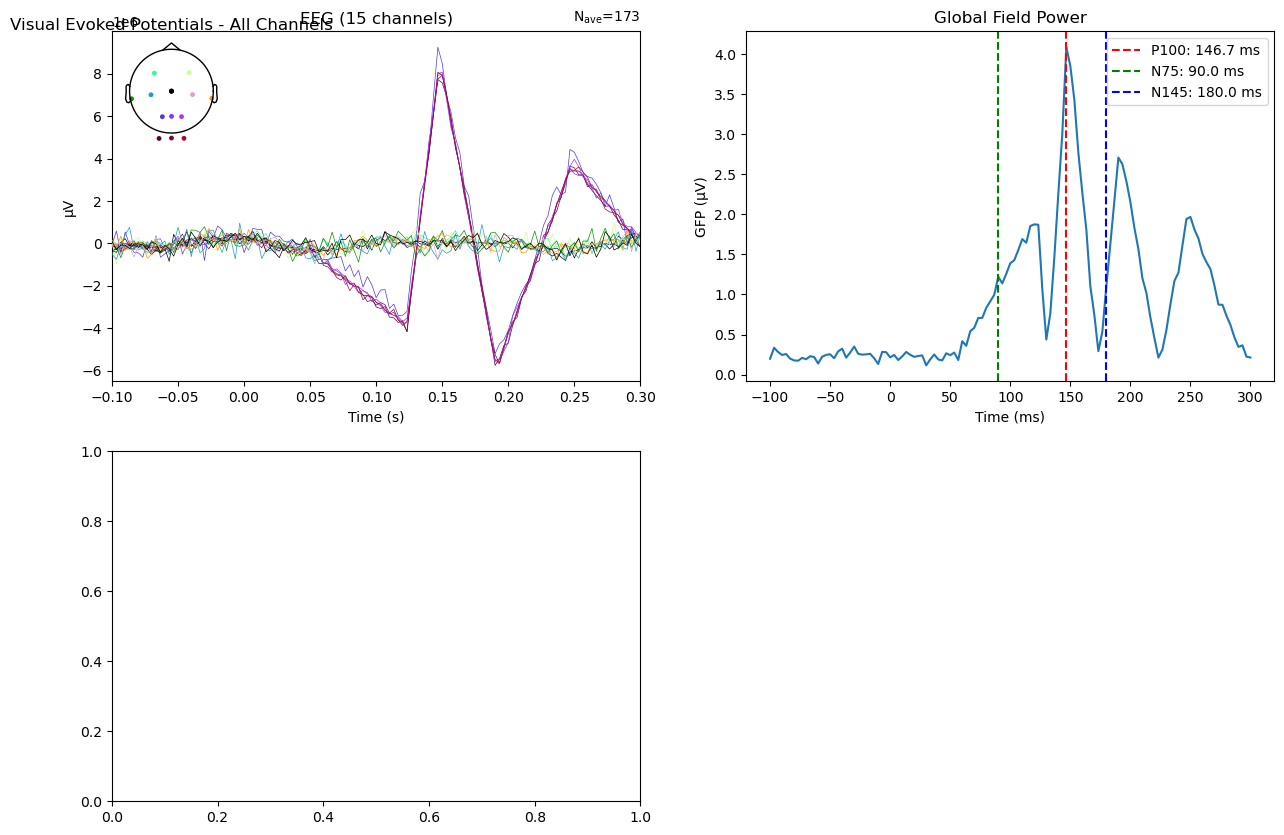

In [2]:
import spkit as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import mne
from scipy import signal
import os


def generate_sample_eeg(condition, duration=30, sfreq=300, n_trials=3, vep_stimulus=False):
    """
    Generate synthetic EEG data for testing the pipeline
    
    Parameters:
    -----------
    condition : str
        'eyes_open' or 'eyes_closed' for alpha wave analysis
        'vep' for visual evoked potential data
    duration : float
        Duration of each trial in seconds
    sfreq : float
        Sampling frequency in Hz
    n_trials : int
        Number of trials to generate
    vep_stimulus : bool
        Whether to include VEP stimulus triggers
    """
    print(f"Generating sample data for {condition} condition...")
    
    # Generate data for multiple trials
    trial_data = []
    
    for trial in range(n_trials):
        n_samples = int(duration * sfreq)
        
        # Define channel configuration: 
        # 6 sponge electrodes (P1, O1, Pz, Oz, P2, O2)
        # 1 disc electrode near Pz
        # 1 TCRE between Pz and Oz
        # Reference (left mastoid) and ground (right mastoid)
        # Total of 15 channels (including computation for bipolar/referential)
        n_channels = 15
        
        # Generate time points
        t = np.arange(n_samples) / sfreq
        
        # Create array for all channels
        data = np.zeros((n_channels, n_samples))
        
        # Alpha wave amplitude - higher for eyes closed
        alpha_amp = 20 if condition == 'eyes_closed' else 5
        
        # Generate EEG signals for each channel
        for ch in range(n_channels):
            # Base signal components
            alpha = alpha_amp * np.sin(2 * np.pi * 10 * t)  # 10 Hz alpha rhythm
            beta = 5 * np.sin(2 * np.pi * 20 * t)    # 20 Hz beta activity
            theta = 7 * np.sin(2 * np.pi * 6 * t)    # 6 Hz theta activity
            
            # Basic EEG with dominant frequencies
            base_signal = alpha + beta + theta
            
            # Noise components
            white_noise = np.random.normal(0, 1, n_samples)
            line_noise = 3 * np.sin(2 * np.pi * 50 * t)  # 50 Hz line noise
            
            # Add random muscle artifacts
            muscle_artifacts = np.zeros(n_samples)
            if np.random.random() < 0.2:  # 20% chance of muscle artifact
                artifact_starts = np.random.choice(n_samples - 300, size=3)
                for start in artifact_starts:
                    artifact_length = np.random.randint(100, 300)
                    muscle_artifacts[start:start+artifact_length] = 20 * np.random.normal(0, 1, artifact_length)
            
            # Add random eye blinks (mainly in frontal channels)
            blinks = np.zeros(n_samples)
            if ch < 2 and np.random.random() < 0.3:  # 30% chance in first 2 channels
                blink_starts = np.random.choice(n_samples - 100, size=int(duration / 10))
                for start in blink_starts:
                    blink = 30 * np.hanning(100)
                    blinks[start:start+100] = blink
            
            # For VEP condition, add visual evoked responses
            vep_response = np.zeros(n_samples)
            if condition == 'vep' and ch in [0, 1, 2, 3, 4, 5]:  # Visual cortex electrodes
                # VEP stimulus timing (1.93 Hz = every 518 ms)
                vep_interval = int(sfreq / 1.93)  # samples between stimuli
                vep_starts = np.arange(0, n_samples - 200, vep_interval)
                
                # VEP waveform (P100 response with proper timing)
                # Create a more realistic VEP waveform based on timing:
                # - N75 occurs ~75ms after stimulus
                # - P100 occurs ~100ms after stimulus 
                # - N145 occurs ~145ms after stimulus
                # - P200 occurs ~200ms after stimulus
                n75_samples = int(0.075 * sfreq)
                p100_samples = int(0.100 * sfreq)
                n145_samples = int(0.145 * sfreq)
                p200_samples = int(0.200 * sfreq)
                
                # Pre-stimulus baseline
                pre_stimulus = np.zeros(int(0.050 * sfreq))
                
                # Create components with realistic timing
                baseline_to_n75 = np.linspace(0, -5, n75_samples)
                n75_to_p100 = np.linspace(-5, 10, p100_samples - n75_samples)
                p100_to_n145 = np.linspace(10, -7, n145_samples - p100_samples)
                n145_to_p200 = np.linspace(-7, 5, p200_samples - n145_samples)
                p200_to_baseline = np.linspace(5, 0, int(0.050 * sfreq))
                
                # Combine components for realistic VEP waveform
                vep_shape = np.concatenate([
                    pre_stimulus,
                    baseline_to_n75,
                    n75_to_p100,
                    p100_to_n145,
                    n145_to_p200,
                    p200_to_baseline
                ])
                
                # Add VEP responses at each stimulus
                for start in vep_starts:
                    if start + len(vep_shape) < n_samples:
                        vep_response[start:start+len(vep_shape)] += vep_shape
            
            # Generate different signal quality based on electrode type
            # Channels 0-5: Sponge electrodes (P1, O1, Pz, Oz, P2, O2)
            # Channel 6: Disc electrode
            # Channel 7: TCRE
            if ch < 6:  # Sponge electrodes
                signal_quality = 0.8
            elif ch == 6:  # Disc electrode
                signal_quality = 0.9
            elif ch == 7:  # TCRE
                signal_quality = 0.85
            else:  # Reference channels
                signal_quality = 0.7
            
            # Combine signal components with quality-dependent weights
            signal_data = (
                signal_quality * (base_signal + vep_response) + 
                (1 - signal_quality) * 10 * white_noise + 
                line_noise * (1 - signal_quality) + 
                muscle_artifacts + 
                blinks
            )
            
            data[ch] = signal_data
        
        trial_data.append(data)
    
    # Combine trials
    combined_data = np.hstack(trial_data)
    
    # Add trigger channel for VEP
    if vep_stimulus:
        trigger_channel = np.zeros((1, combined_data.shape[1]))
        vep_interval = int(sfreq / 1.93)  # samples between stimuli
        
        # Set trigger to 1 at stimulus onset
        for trial in range(n_trials):
            trial_start = trial * int(duration * sfreq)
            vep_starts = np.arange(trial_start, trial_start + int(duration * sfreq) - 10, vep_interval)
            for start in vep_starts:
                if start < combined_data.shape[1]:
                    trigger_channel[0, start] = 1
        
        # Add trigger channel to data
        combined_data = np.vstack([combined_data, trigger_channel])
    
    # Save as CSV
    os.makedirs("data", exist_ok=True)
    df = pd.DataFrame(combined_data.T)
    
    # Channel names - include all required electrodes
    channel_names = ['P1', 'O1', 'Pz', 'Oz', 'P2', 'O2', 'Disc_Pz', 'TCRE_PzOz', 
                     'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'Ref']
    
    if vep_stimulus:
        channel_names.append('Trigger')
    
    df.columns = channel_names
    
    filepath = f"./data/{condition}_{n_trials}trials.csv"
    df.to_csv(filepath, index=False)
    
    return filepath


def Load_Raw(path, sfreq=300, plot_raw=False):
    """
    Load EEG data from CSV file
    
    Parameters:
    -----------
    path : str
        Path to the CSV file
    sfreq : float
        Sampling frequency
    plot_raw : bool
        Whether to plot the raw data
        
    Returns:
    --------
    raw : mne.io.Raw
        MNE Raw object containing the EEG data
    """
    # Read CSV file
    df = pd.read_csv(path)
    
    # Check if there's a trigger channel
    has_trigger = 'Trigger' in df.columns
    
    # Extract EEG data
    if has_trigger:
        eeg_data = df.iloc[:, :-1].values.T
        trigger_data = df['Trigger'].values.reshape(1, -1)
    else:
        eeg_data = df.values.T
    
    # Get channel names
    eeg_channels = list(df.columns)
    if has_trigger:
        eeg_channels = eeg_channels[:-1]
    
    # Define channel types
    ch_types = ['eeg'] * len(eeg_channels)
    
    # Create MNE info
    info = mne.create_info(eeg_channels, sfreq, ch_types=ch_types)
    
    # Create Raw object
    raw = mne.io.RawArray(eeg_data, info)
    
    # Set montage for standard electrodes
    standard_montage = mne.channels.make_standard_montage('standard_1020')
    
    # Get the subset of channels that exist in the standard montage
    standard_channels = [ch for ch in eeg_channels if ch in standard_montage.ch_names]
    
    if standard_channels:
        # Create a new montage with only the standard channels
        ch_pos = {ch: standard_montage.get_positions()['ch_pos'][ch] for ch in standard_channels}
        subset_montage = mne.channels.make_dig_montage(ch_pos=ch_pos)
        
        # Apply the montage to the subset of channels
        raw.set_montage(subset_montage, on_missing='warn')
    
    # Add trigger channel if present
    if has_trigger:
        trigger_info = mne.create_info(['Trigger'], sfreq, ['stim'])
        trigger_raw = mne.io.RawArray(trigger_data, trigger_info)
        raw.add_channels([trigger_raw], force_update_info=True)
    
    if plot_raw:
        raw.plot(scalings='auto')
    
    return raw


def Analyze_Alpha_Waves(raw_eyes_open, raw_eyes_closed, fmin=8, fmax=13):
    """
    Compare alpha waves between eyes open and eyes closed conditions
    
    Parameters:
    -----------
    raw_eyes_open : mne.io.Raw
        Raw data for eyes open condition
    raw_eyes_closed : mne.io.Raw
        Raw data for eyes closed condition
    fmin : float
        Minimum frequency for alpha band
    fmax : float
        Maximum frequency for alpha band
        
    Returns:
    --------
    results : dict
        Dictionary containing alpha power and comparison metrics
    """
    print("Analyzing alpha waves between eyes open and closed conditions...")
    
    # Calculate PSDs for both conditions
    fmin_psd, fmax_psd = 1, 40  # Broader range for visualization
    
    # Updated method for PSD calculation (compatible with newer MNE versions)
    # Eyes open PSD
    psd_open = raw_eyes_open.compute_psd(
        method='welch',
        fmin=fmin_psd, 
        fmax=fmax_psd, 
        n_fft=int(raw_eyes_open.info['sfreq'] * 4),
        n_overlap=int(raw_eyes_open.info['sfreq'] * 2),
        picks='eeg'
    )
    
    # Eyes closed PSD
    psd_closed = raw_eyes_closed.compute_psd(
        method='welch',
        fmin=fmin_psd, 
        fmax=fmax_psd, 
        n_fft=int(raw_eyes_closed.info['sfreq'] * 4),
        n_overlap=int(raw_eyes_closed.info['sfreq'] * 2),
        picks='eeg'
    )
    
    # Extract frequencies and power (updated for newer MNE API)
    freqs_open = psd_open.freqs
    psd_open_data = psd_open.get_data()
    
    freqs_closed = psd_closed.freqs
    psd_closed_data = psd_closed.get_data()
    
    # Find indices corresponding to alpha band
    alpha_idx_open = np.logical_and(freqs_open >= fmin, freqs_open <= fmax)
    alpha_idx_closed = np.logical_and(freqs_closed >= fmin, freqs_closed <= fmax)
    
    # Calculate alpha power for each condition and channel
    alpha_power_open = np.mean(psd_open_data[:, alpha_idx_open], axis=1)
    alpha_power_closed = np.mean(psd_closed_data[:, alpha_idx_closed], axis=1)
    
    # Calculate ratio of alpha power (closed/open)
    alpha_ratio = alpha_power_closed / alpha_power_open
    
    # Visual channels (mostly occipital and parietal)
    visual_channels = [i for i, ch in enumerate(raw_eyes_open.ch_names) 
                      if ch in ['O1', 'O2', 'Oz', 'P1', 'P2', 'Pz']]
    
    if not visual_channels:
        print("Warning: No visual channels found for alpha analysis.")
        visual_channels = list(range(min(6, len(raw_eyes_open.ch_names))))
    
    # Calculate metrics
    mean_alpha_open = np.mean(alpha_power_open[visual_channels])
    mean_alpha_closed = np.mean(alpha_power_closed[visual_channels])
    mean_ratio_visual = np.mean(alpha_ratio[visual_channels])
    
    # Prepare results
    results = {
        'freqs': freqs_open,
        'psd_open': psd_open,
        'psd_closed': psd_closed,
        'alpha_power_open': alpha_power_open,
        'alpha_power_closed': alpha_power_closed,
        'alpha_ratio': alpha_ratio,
        'mean_alpha_open': mean_alpha_open,
        'mean_alpha_closed': mean_alpha_closed,
        'mean_ratio_visual': mean_ratio_visual,
        'channel_names': raw_eyes_open.ch_names
    }
    
    # Plot the results
    plt.figure(figsize=(15, 10))
    
    # Plot 1: PSD for visual channels
    plt.subplot(2, 2, 1)
    for ch_idx in visual_channels:
        plt.plot(freqs_open, psd_open_data[ch_idx], alpha=0.3, color='blue')
        plt.plot(freqs_closed, psd_closed_data[ch_idx], alpha=0.3, color='red')
    
    # Add average PSD
    plt.plot(freqs_open, np.mean(psd_open_data[visual_channels], axis=0), linewidth=2, color='blue', label='Eyes Open')
    plt.plot(freqs_closed, np.mean(psd_closed_data[visual_channels], axis=0), linewidth=2, color='red', label='Eyes Closed')
    
    plt.title('Power Spectral Density - Visual Cortex Channels')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (µV²/Hz)')
    plt.xlim([fmin_psd, fmax_psd])
    plt.legend()
    
    # Plot 2: Alpha power comparison by channel
    plt.subplot(2, 2, 2)
    bar_width = 0.35
    indices = np.arange(len(visual_channels))
    
    plt.bar(indices - bar_width/2, alpha_power_open[visual_channels], bar_width, label='Eyes Open', color='blue')
    plt.bar(indices + bar_width/2, alpha_power_closed[visual_channels], bar_width, label='Eyes Closed', color='red')
    
    plt.title('Alpha Power by Channel')
    plt.xlabel('Channel')
    plt.ylabel('Alpha Power (µV²/Hz)')
    plt.xticks(indices, [raw_eyes_open.ch_names[i] for i in visual_channels])
    plt.legend()
    
    # Plot 3: Alpha ratio (closed/open)
    plt.subplot(2, 2, 3)
    plt.bar(indices, alpha_ratio[visual_channels], color='purple')
    plt.axhline(y=1, color='k', linestyle='--')
    
    plt.title('Alpha Power Ratio (Closed/Open)')
    plt.xlabel('Channel')
    plt.ylabel('Ratio')
    plt.xticks(indices, [raw_eyes_open.ch_names[i] for i in visual_channels])
    
    # Plot 4: Mean alpha power comparison
    plt.subplot(2, 2, 4)
    plt.bar(['Eyes Open', 'Eyes Closed'], [mean_alpha_open, mean_alpha_closed], color=['blue', 'red'])
    
    plt.title('Mean Alpha Power - Visual Cortex')
    plt.ylabel('Alpha Power (µV²/Hz)')
    
    plt.tight_layout()
    plt.savefig("results/alpha_wave_analysis.png")
    plt.show()
    
    # Print results
    print(f"Mean alpha power (eyes open): {mean_alpha_open:.2f} µV²/Hz")
    print(f"Mean alpha power (eyes closed): {mean_alpha_closed:.2f} µV²/Hz")
    print(f"Alpha power ratio (closed/open): {mean_ratio_visual:.2f}")
    
    return results


def Analyze_VEP(raw_vep, tmin=-0.1, tmax=0.3, baseline=(-0.1, 0)):
    """
    Analyze Visual Evoked Potentials by segmenting data around triggers
    
    Parameters:
    -----------
    raw_vep : mne.io.Raw
        Raw data with VEP recordings and trigger channel
    tmin : float
        Start time for epoch window relative to trigger (in seconds)
    tmax : float
        End time for epoch window relative to trigger (in seconds)
    baseline : tuple
        Baseline correction period (in seconds)
        
    Returns:
    --------
    results : dict
        Dictionary containing VEP analysis results
    """
    print("Analyzing Visual Evoked Potentials...")
    
    # Check if trigger channel exists
    if 'Trigger' not in raw_vep.ch_names:
        print("Error: Trigger channel not found. Cannot segment VEP data.")
        print("Creating synthetic triggers at 1.93 Hz as specified in protocol...")
        
        # Create synthetic triggers at 1.93 Hz
        sfreq = raw_vep.info['sfreq']
        n_samples = len(raw_vep.times)
        
        # Calculate trigger interval in samples (518 ms between triggers at 1.93 Hz)
        trigger_interval = int(sfreq / 1.93)
        
        # Create synthetic events
        event_times = np.arange(0, n_samples - trigger_interval, trigger_interval)
        events = np.zeros((len(event_times), 3), dtype=int)
        events[:, 0] = event_times  # Event time
        events[:, 2] = 1            # Event value
    else:
        # Find events from trigger channel
        events = mne.find_events(raw_vep, stim_channel='Trigger', verbose=True)
    
    if len(events) == 0:
        print("Error: No events found in trigger channel.")
        return None
    
    print(f"Found {len(events)} visual stimulus events at ~1.93 Hz (518 ms interval).")
    
    # Create epochs around triggers
    epochs = mne.Epochs(
        raw_vep, 
        events, 
        tmin=tmin, 
        tmax=tmax, 
        baseline=baseline, 
        picks='eeg',
        preload=True,
        verbose=True
    )
    
    # Get averaged evoked response
    evoked = epochs.average()
    
    # Calculate Global Field Power (GFP)
    gfp = np.std(evoked.data, axis=0)
    
    # Find latency of main peaks
    times = evoked.times * 1000  # Convert to ms
    
    # Look for peak within expected P100 time range (75-150 ms)
    p100_window = np.logical_and(times >= 75, times <= 150)
    p100_latency = times[p100_window][np.argmax(gfp[p100_window])]
    
    # Look for N75 peak (before P100, usually around 75ms)
    n75_window = np.logical_and(times >= 50, times <= 90)
    n75_latency = times[n75_window][np.argmin(np.mean(evoked.data[:, n75_window], axis=0))]
    
    # Look for N145 peak (after P100, usually around 145ms)
    n145_window = np.logical_and(times >= 130, times <= 180)
    n145_latency = times[n145_window][np.argmin(np.mean(evoked.data[:, n145_window], axis=0))]
    
    # Calculate metrics
    p100_amplitude = np.max(gfp[p100_window])
    
    # Prepare results
    results = {
        'evoked': evoked,
        'gfp': gfp,
        'times': times,
        'p100_latency': p100_latency,
        'p100_amplitude': p100_amplitude,
        'n75_latency': n75_latency,
        'n145_latency': n145_latency
    }
    
    # Plot the results
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Evoked potentials for all channels
    plt.subplot(2, 2, 1)
    evoked.plot(axes=plt.gca(), show=False)
    plt.title('Visual Evoked Potentials - All Channels')
    
    # Plot 2: GFP
    plt.subplot(2, 2, 2)
    plt.plot(times, gfp)
    plt.axvline(x=p100_latency, color='r', linestyle='--', label=f'P100: {p100_latency:.1f} ms')
    plt.axvline(x=n75_latency, color='g', linestyle='--', label=f'N75: {n75_latency:.1f} ms')
    plt.axvline(x=n145_latency, color='b', linestyle='--', label=f'N145: {n145_latency:.1f} ms')
    
    plt.title('Global Field Power')
    plt.xlabel('Time (ms)')
    plt.ylabel('GFP (µV)')
    plt.legend()
    
    # Plot 3: Topography at P100
    p100_idx = np.argmin(np.abs(times - p100_latency))
    plt.subplot(2, 2, 3)
    evoked.plot_topomap(times=times[p100_idx]/1000, axes=plt.gca(), show=False)
    plt.title(f'Topography at P100 ({p100_latency:.1f} ms)')
    
    # Plot 4: Response for visual channels
    plt.subplot(2, 2, 4)
    visual_channels = [i for i, ch in enumerate(evoked.ch_names) 
                      if ch in ['O1', 'O2', 'Oz', 'P1', 'P2', 'Pz']]
    
    if not visual_channels:
        print("Warning: No visual channels found for VEP analysis.")
        visual_channels = list(range(min(6, len(evoked.ch_names))))
    
    for ch_idx in visual_channels:
        plt.plot(times, evoked.data[ch_idx], label=evoked.ch_names[ch_idx])
    
    plt.axvline(x=0, color='k', linestyle='--')
    plt.axhline(y=0, color='k', linestyle='--')
    
    plt.title('VEP - Visual Cortex Channels')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("results/vep_analysis.png")
    plt.show()
    
    # Print results
    print(f"P100 latency: {p100_latency:.1f} ms")
    print(f"P100 amplitude: {p100_amplitude:.2f} µV")
    print(f"N75 latency: {n75_latency:.1f} ms")
    print(f"N145 latency: {n145_latency:.1f} ms")
    
    return results


def Compare_Electrode_Types_VEP(raw_vep):
    """
    Compare VEP recordings from different electrode types (sponge, disc, TCRE)
    
    Parameters:
    -----------
    raw_vep : mne.io.Raw
        Raw data with VEP recordings and trigger channel
        
    Returns:
    --------
    results : dict
        Dictionary containing comparison results
    """
    print("Comparing electrode types for VEP recordings...")
    
    # Define electrode types
    electrode_types = {
        'sponge': ['P1', 'O1', 'Pz', 'Oz', 'P2', 'O2'],
        'disc': ['Disc_Pz'],
        'tcre': ['TCRE_PzOz']
    }
    
    # Check if electrodes exist in data
    for e_type, channels in electrode_types.items():
        missing = [ch for ch in channels if ch not in raw_vep.ch_names]
        if missing:
            print(f"Warning: Missing {e_type} electrodes: {missing}")
    
    # Find events
    events = mne.find_events(raw_vep, stim_channel='Trigger')
    
    if len(events) == 0:
        print("Error: No events found in trigger channel.")
        return None
    
    # Create epochs
    epochs = mne.Epochs(
        raw_vep, 
        events, 
        tmin=-0.1, 
        tmax=0.3, 
        baseline=(-0.1, 0), 
        preload=True
    )
    
    # Analysis for each electrode type
    results = {}
    
    for e_type, channels in electrode_types.items():
        # Skip if no channels for this type
        available_channels = [ch for ch in channels if ch in raw_vep.ch_names]
        if not available_channels:
            continue
        
        # Pick channels for this electrode type
        pick_indices = [raw_vep.ch_names.index(ch) for ch in available_channels]
        
        # Average channels for this type
        evoked = epochs.copy().pick(available_channels).average()
        
        # Calculate SNR
        # Use pre-stimulus period as noise estimate
        signal = evoked.data
        noise_period = np.where(evoked.times < 0)[0]
        noise = np.std(evoked.data[:, noise_period], axis=1)
        
        # P100 period
        p100_period = np.where((evoked.times >= 0.075) & (evoked.times <= 0.150))[0]
        
        # Peak-to-peak amplitude in P100 period
        peak_to_peak = np.max(evoked.data[:, p100_period], axis=1) - np.min(evoked.data[:, p100_period], axis=1)
        
        # SNR
        snr = peak_to_peak / (noise + 1e-10)  # Add small constant to avoid division by zero
        
        # Find P100 latency
        p100_latency = []
        for ch in range(evoked.data.shape[0]):
            p100_idx = p100_period[np.argmax(evoked.data[ch, p100_period])]
            p100_latency.append(evoked.times[p100_idx] * 1000)  # Convert to ms
        
        results[e_type] = {
            'evoked': evoked,
            'snr': np.mean(snr),
            'p100_latency': np.mean(p100_latency),
            'peak_amplitude': np.mean(np.max(evoked.data[:, p100_period], axis=1))
        }
    
    # Plot comparison
    plt.figure(figsize=(15, 10))
    
    # Plot 1: VEP waveforms
    plt.subplot(2, 2, 1)
    for e_type, data in results.items():
        avg_signal = np.mean(data['evoked'].data, axis=0)
        plt.plot(data['evoked'].times * 1000, avg_signal, label=e_type.capitalize())
    
    plt.axvline(x=0, color='k', linestyle='--')
    plt.axhline(y=0, color='k', linestyle='--')
    
    plt.title('VEP Waveform Comparison by Electrode Type')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    
    # Plot 2: SNR comparison
    plt.subplot(2, 2, 2)
    e_types = list(results.keys())
    snr_values = [results[e_type]['snr'] for e_type in e_types]
    
    plt.bar(e_types, snr_values)
    plt.title('Signal-to-Noise Ratio')
    plt.ylabel('SNR')
    plt.xticks(e_types, [e.capitalize() for e in e_types])
    
    # Plot 3: P100 latency comparison
    plt.subplot(2, 2, 3)
    latency_values = [results[e_type]['p100_latency'] for e_type in e_types]
    
    plt.bar(e_types, latency_values)
    plt.title('P100 Latency')
    plt.ylabel('Latency (ms)')
    plt.xticks(e_types, [e.capitalize() for e in e_types])
    
    # Plot 4: Peak amplitude comparison
    plt.subplot(2, 2, 4)
    amplitude_values = [results[e_type]['peak_amplitude'] for e_type in e_types]
    
    plt.bar(e_types, amplitude_values)
    plt.title('Peak Amplitude')
    plt.ylabel('Amplitude (µV)')
    plt.xticks(e_types, [e.capitalize() for e in e_types])
    
    plt.tight_layout()
    plt.savefig("results/electrode_type_comparison.png")
    plt.show()
    
    # Print results
    print("\nElectrode Type Comparison:")
    for e_type in e_types:
        print(f"{e_type.capitalize()}:")
        print(f"  SNR: {results[e_type]['snr']:.2f}")
        print(f"  P100 Latency: {results[e_type]['p100_latency']:.1f} ms")
        print(f"  Peak Amplitude: {results[e_type]['peak_amplitude']:.2f} µV")
    
    return results


def test_run():
    """Run a test with synthetic data to verify the pipeline works"""
    print("\n=== Running test with synthetic data ===\n")
    
    # Create directories if they don't exist
    os.makedirs("data", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    
    print("Generating 3 sets of eyes open/closed recordings (30 seconds each)...")
    
    # Generate sample data for eyes open/closed conditions (3 trials of 30 seconds each)
    path_eyes_open = generate_sample_eeg('eyes_open', duration=30, n_trials=3)
    path_eyes_closed = generate_sample_eeg('eyes_closed', duration=30, n_trials=3)
    
    print("Generating visual evoked potential data (checkerboard pattern at 1.93 Hz)...")
    
    # Generate sample data for VEP (with stimulus triggers at 1.93 Hz)
    path_vep = generate_sample_eeg('vep', duration=30, n_trials=3, vep_stimulus=True)
    
    print("Loading and preprocessing data...")
    
    # Load data
    raw_eyes_open = Load_Raw(path_eyes_open)
    raw_eyes_closed = Load_Raw(path_eyes_closed)
    raw_vep = Load_Raw(path_vep)
    
    # Analyze alpha waves (compare eyes open vs. closed)
    alpha_results = Analyze_Alpha_Waves(raw_eyes_open, raw_eyes_closed)
    
    # Analyze VEP (segmentation and ensemble averaging)
    # Window: 100ms pre-stimulus to 300ms post-stimulus
    vep_results = Analyze_VEP(raw_vep, tmin=-0.1, tmax=0.3)
    
    # Compare electrode types for VEP
    electrode_comparison = Compare_Electrode_Types_VEP(raw_vep)
    
    # Save results
    np.save("results/alpha_results.npy", alpha_results)
    np.save("results/vep_results.npy", vep_results)
    np.save("results/electrode_comparison.npy", electrode_comparison)
    
    print("\n=== Test run completed successfully! ===")
    print("Sample data files are in the 'data' folder.")
    print("Analysis results are in the 'results' folder.")
    print("Use the main() function with your real data when ready.")


def main(use_sample_data=False):
    """
    Main function to process EEG data and perform analyses
    
    Parameters:
    -----------
    use_sample_data : bool
        If True, generates and uses synthetic test data.
        If False, expects real data files in the data folder.
    """
    # Create directories if they don't exist
    os.makedirs("data", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    
    if use_sample_data:
        test_run()
        return
    
    # File paths for real data
    eyes_open_paths = []
    eyes_closed_paths = []
    vep_paths = []
    
    # Check for existing data files
    for file in os.listdir("data"):
        if file.startswith("eyes_open"):
            eyes_open_paths.append(os.path.join("data", file))
        elif file.startswith("eyes_closed"):
            eyes_closed_paths.append(os.path.join("data", file))
        elif file.startswith("vep"):
            vep_paths.append(os.path.join("data", file))
    
    # Validate that we have data to analyze
    if not eyes_open_paths:
        print("Warning: No eyes open data files found.")
    if not eyes_closed_paths:
        print("Warning: No eyes closed data files found.")
    if not vep_paths:
        print("Warning: No VEP data files found.")
    
    # Alpha wave analysis
    if eyes_open_paths and eyes_closed_paths:
        print("\n=== Running alpha wave analysis ===")
        
        # Load data from first files found
        raw_eyes_open = Load_Raw(eyes_open_paths[0])
        raw_eyes_closed = Load_Raw(eyes_closed_paths[0])
        
        # Analyze alpha waves
        alpha_results = Analyze_Alpha_Waves(raw_eyes_open, raw_eyes_closed)
        np.save("results/alpha_results.npy", alpha_results)
    
    # VEP analysis
    if vep_paths:
        print("\n=== Running VEP analysis ===")
        
        # Load data
        raw_vep = Load_Raw(vep_paths[0])
        
        # Analyze VEP - use window of approximately 400ms total
        # (50-100ms pre-stimulus, 300-400ms post-stimulus as specified)
        vep_results = Analyze_VEP(raw_vep, tmin=-0.1, tmax=0.3)
        
        # Compare electrode types
        electrode_comparison = Compare_Electrode_Types_VEP(raw_vep)
        
        # Save results
        if vep_results:
            np.save("results/vep_results.npy", vep_results)
        if electrode_comparison:
            np.save("results/electrode_comparison.npy", electrode_comparison)
    
    print("\n=== Analysis completed successfully! ===")
    print("Results are in the 'results' folder.")


if __name__ == "__main__":
    # Run with sample data for testing
    main(use_sample_data=True)
    
    print("\nTo use with your own data:")
    print("1. Place your EEG data files in the 'data' folder with appropriate names:")
    print("   - eyes_open_*.csv for eyes open recordings")
    print("   - eyes_closed_*.csv for eyes closed recordings")
    print("   - vep_*.csv for visual evoked potential recordings")
    print("2. Ensure your CSV files have channel names as headers")
    print("3. Run the script with use_sample_data=False in the main() function")